# Data Analysis - Income and Houshold Size

Steps:

1 - Find percent change on cantonal or regional level
    Are there trends? Form groups of small communes vs big communes
    
2 - Extrapolate Income on communal level 2007 - 2016

3 - Analyse correlation(pearson R) between HH-size and Income on communal level

## Steps from Workbook DataAnalysis

In [123]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [98]:
data_folder = './data/wrangled_data/'
data_incomes = './data/Incomes.csv'
map_folder = './data/map_data/'

In [120]:
# the cleaned and wrangled data from the notebook "Data Wrangling" is imported and numerous arrays are created
array_names = []

for i in os.listdir(data_folder):
    globals()['%s' %i[:-4]] = pd.read_csv(data_folder + str(i))
    array_names.append(i[:-4])


### Extrapolation of Income Table
The only data available of incomes on communal level is for the year 2007. 
Here we analyse the income data for the regions and anylse whether there has been change between 2008 and 2016: 

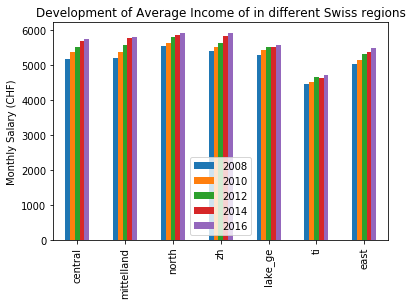

In [4]:
#load Income data
incomes = pd.read_csv(data_folder + 'Incomes.csv')

#create table for median incomes for all regions and years available
regions = ['central', 'mittelland', 'north', 'zh', 'lake_ge', 'ti', 'east']
wages_years = ['2008', '2010', '2012', '2014', '2016']
med_income_region = pd.DataFrame(columns=wages_years, index=regions)

for region in regions:
    for year in wages_years:
        med_income_region.loc[region,year] = float(globals()['wages%s' %year+region].total_median[0])

med_income_region.plot(kind='bar')
plt.title('Development of Average Income of in different Swiss regions')
plt.ylabel('Monthly Salary (CHF)')
plt.show()

From the Graph above, we can see that there is a change in income over the years, and that the incomes changes differntly in the different regions. E.g. In Ticino the year 2014 is lower than 2012, whereas for the other regions it is always increasing.

-> We need to extraploate our income data from 2007.

**Approach for Extrapolation:**
- Development from 2008 till 2012 for every two years available
- We assume no change between 2008 and 2007 as we have no data
- Take 2008 as reference year and calculate percent change to years 2010, 2012, 2014 and 2016
- To fill even years: Assume same change for every commune of the region and calculate incomes for every commune for the years mentioned above
- e.g. Commune(2012, region=ti) = Commune(2008, region = ti) * Ti(2012)/Ti(2008)
- To fill odd years(where no wages of regions is available) -> take average between year before and after

In [5]:
#prepare extrapolation dataframe: add data for 2008 (=incomes2007) and join on cantons to know region of commune
cantons = pd.read_csv(data_folder + 'cantons.csv')
header = ['Name', 'canton', '2008', '2010', '2012', '2014', '2016']
med_incomes = pd.DataFrame(columns=header, index=incomes.ID)
med_incomes[['Name','canton','2008']]=incomes[['NAME', 'KT', 'MEDREV']]
med_incomes= med_incomes.merge(cantons,left_on='canton', right_on='Kantonsnr').drop(columns=['canton'])

#extrapolate linearly from 2008 to dates for even numbers
wages_years = ['2008', '2010', '2012', '2014', '2016']

for ind in range(0,med_incomes.shape[0]): 
    for year in wages_years:
        region= med_incomes.loc[ind,'region']
        med_incomes.loc[ind,year] = med_incomes.loc[ind,'2008']*med_income_region.loc[region,year]/med_income_region.loc[region,'2008'] 

#take average for odd years


        
med_incomes.head(5)

,Name,2008,2010,2012,2014,2016,code,Kantonsnr,region
0,Affoltern am Albis,52.0200,52.9615,54.2872,56.1605,56.881,ZH,1,zh
1,Bonstetten,62.8786,64.0166,65.619,67.8833,68.7542,ZH,1,zh
2,Hausen am Albis,55.9826,56.9958,58.4225,60.4385,61.2138,ZH,1,zh
3,Hedingen,58.8480,59.913,61.4128,63.5319,64.347,ZH,1,zh
4,Kappel am Albis,56.7883,57.816,59.2633,61.3083,62.0948,ZH,1,zh


In [6]:
#prepare extrapolation dataframe: add data for 2008 (=incomes2007) and join on cantons to know region of commune
cantons = pd.read_csv(data_folder + 'cantons.csv')
header = ['Name', 'canton', '2008', '2009', '2010', '2011','2012', '2013', '2014', '2015','2016']
med_incomes = pd.DataFrame(columns=header, index=incomes.ID)
med_incomes[['Name','canton','2008']]=incomes[['NAME', 'KT', 'MEDREV']]
med_incomes= med_incomes.merge(cantons,left_on='canton', right_on='Kantonsnr').drop(columns=['canton'])

#extrapolate linearly from 2008 to dates for even numbers
even_years = ['2010', '2012', '2014', '2016']
for ind in range(0,med_incomes.shape[0]): 
    for year in wages_years:
        region= med_incomes.loc[ind,'region']
        med_incomes.loc[ind,year] = med_incomes.loc[ind,'2008']*med_income_region.loc[region,year]/med_income_region.loc[region,'2008'] 

#take average for odd years
odd_years = ['2009','2011', '2013', '2015']
for ind in range(0,med_incomes.shape[0]):
    for year in odd_years:
        y = int(year)
        med_incomes.loc[ind,year] = (med_incomes.loc[ind, str(y+1)] + med_incomes.loc[ind, str(y-1)])/2
        
med_incomes.head(5)

,Name,2008,2009,2010,2011,2012,2013,2014,2015,2016,code,Kantonsnr,region
0,Affoltern am Albis,52.0200,52.4907,52.9615,53.6243,54.2872,55.2238,56.1605,56.5207,56.881,ZH,1,zh
1,Bonstetten,62.8786,63.4476,64.0166,64.8178,65.619,66.7512,67.8833,68.3188,68.7542,ZH,1,zh
2,Hausen am Albis,55.9826,56.4892,56.9958,57.7091,58.4225,59.4305,60.4385,60.8262,61.2138,ZH,1,zh
3,Hedingen,58.8480,59.3805,59.913,60.6629,61.4128,62.4723,63.5319,63.9395,64.347,ZH,1,zh
4,Kappel am Albis,56.7883,57.3022,57.816,58.5397,59.2633,60.2858,61.3083,61.7016,62.0948,ZH,1,zh


## Correlation Analysis : Income - Share of Houshold Sizes

**Approach:** 
Merge extrapolated income to the corresponding datatable of the Houshold sizes. And then scatter plot it. A function is defined that plots all HH sizes for 1 year. 

Issue: Due to the fusion of communes, every year the number of communes decreases. However, for a correlation analysis the number of communes compared must be equal. We therefore can only compare the communes we have data in common.

In [7]:
def plot_hh_corr(hh_sizes, year):
    
    #merge frames to keep only available columns and return number of commune in common
    merged = pd.merge(left=hh_sizes, right=med_incomes[['Name',year]], how='inner', left_on='Commune', right_on='Name').drop(columns=['Name','Unnamed: 0'])
    print("Comment: %i out of %i communes rest after merging" %(merged.shape[0], incomes.shape[0]))
    
    #calculate the share of hh sizes for every commune
    merged.iloc[:,2:8] = merged.iloc[:,2:8].div(merged['Total'].values,axis=0)
    
    #plotting
    plt.figure(figsize=(20,10))
    plt.suptitle("Correlation Analysis for Year %s" %year)
    
    plt.subplot(231)
    plt.scatter(data=merged, x=year, y="1HH", s=0.2 )
    plt.xlabel("Average Yearly Income (1000CHF)")
    plt.ylabel("Share of 1-person households")
    
    plt.subplot(232)
    plt.scatter(data=merged, x=year, y="2HH", s=0.2 )
    plt.xlabel("Average Yearly Income (1000CHF)")
    plt.ylabel("Share of 2-person households")
    
    plt.subplot(233)
    plt.scatter(data=merged, x=year, y="3HH", s=0.2 )
    plt.xlabel("Average Yearly Income (1000CHF)")
    plt.ylabel("Share of 3-person households")
               
    plt.subplot(234)
    plt.scatter(data=merged, x=year, y="4HH", s=0.2 )
    plt.xlabel("Average Yearly Income (1000CHF)")
    plt.ylabel("Share of 4-person households")           
               
    plt.subplot(235)
    plt.scatter(data=merged, x=year, y="5HH", s=0.2 )
    plt.xlabel("Average Yearly Income (1000CHF)")
    plt.ylabel("Share of 4-person households")  
    
    plt.subplot(236)
    plt.scatter(data=merged, x=year, y="6HH", s=0.2 )       
    plt.xlabel("Average Yearly Income (1000CHF)")
    plt.ylabel("Share of 6 or more person households")  
    
    plt.show()

To avoid the notebook getting to large, only one example year is displayed here. But the year to display can easily be changed.

Comment: 2188 out of 2727 communes rest after merging


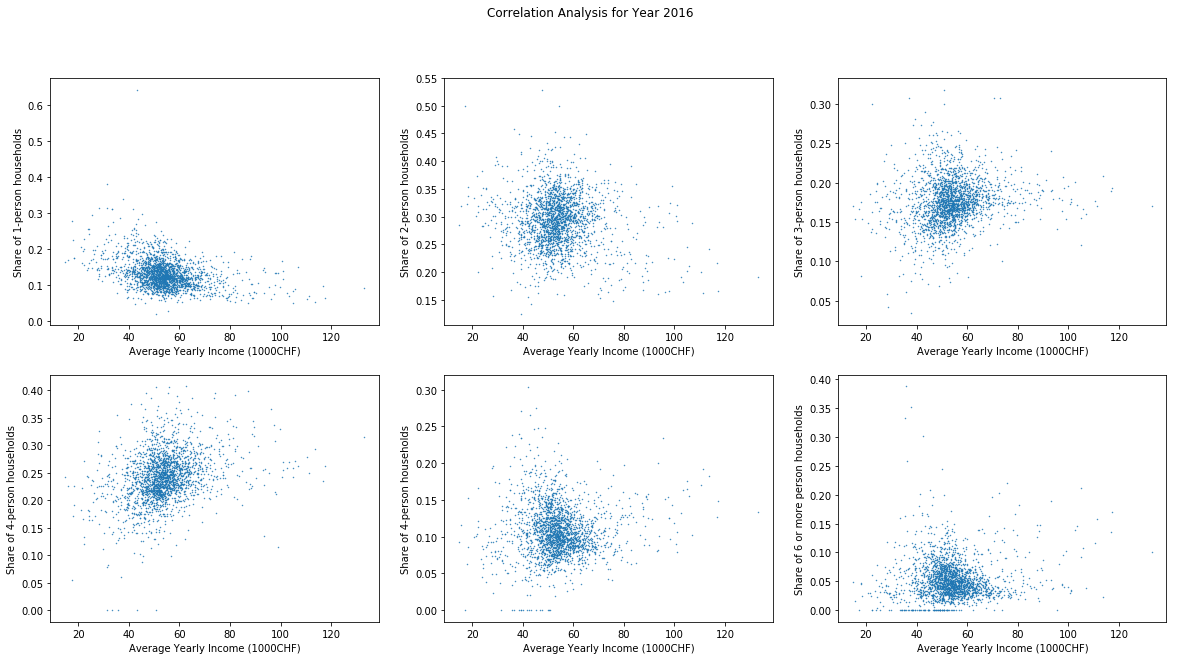

In [12]:
#scatter plot the shares of hh sizes for a chosen example year
plot_hh_corr(hh_sizes2016, "2016")

After looking at the data clouds for all years, we wanted to know the correlation coefficients and its p-value. In order to plot, we fill out a table with all Pearson r values for all correlation between income and different HHsizes, for all available years. Same is done for p-values.

In [17]:
#create table for median incomes for all regions and years available
HHsizes = ['1HH','2HH', '3HH', '4HH','5HH','6HH']
years = ['2010', '2011', '2012', '2013', '2014', '2015','2016']

hh_income_r = pd.DataFrame(columns=years, index=HHsizes)
hh_income_p = pd.DataFrame(columns=years, index=HHsizes)

def fill_hh_correlations(hh_sizes, year):

    #merge frames to keep only available columns and return number of commune in common
    merged = pd.merge(left=hh_sizes, right=med_incomes[['Name',year]], how='inner', left_on='Commune', right_on='Name').drop(columns=['Name','Unnamed: 0'])
    #print("%i out of %i communes are analysed after merging" %(merged.shape[0], incomes.shape[0]))
    
    #calculate the share of hh sizes for every commune
    merged.iloc[:,2:8] = merged.iloc[:,2:8].div(merged['Total'].values,axis=0)
    
    #get Pearson's r and p-value for every HHsize and fill in table
    for hh in ['1HH','2HH', '3HH', '4HH','5HH','6HH']:
        r,p = stats.pearsonr(x=merged[year],y=merged[hh])
        hh_income_r.loc[hh, year] = r
        hh_income_p.loc[hh, year] = p
        
for year in years:
    fill_hh_correlations(hh_sizes=globals()['hh_sizes%s' %year], year=year)
    

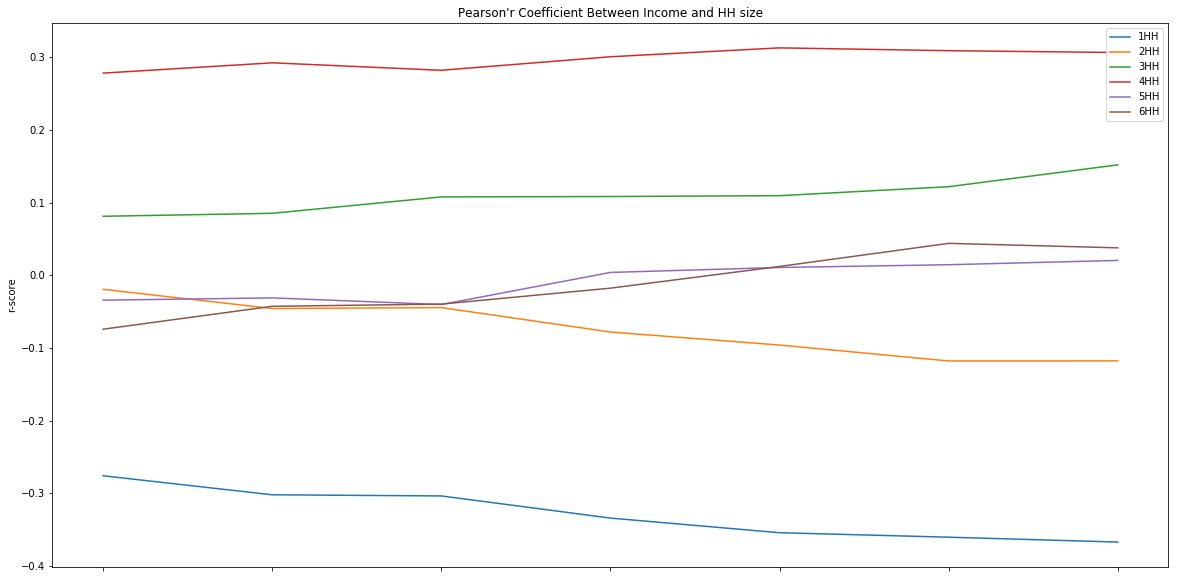

            2010         2011         2012         2013         2014  \
1HH  3.89956e-45  1.52421e-52  8.66545e-53   1.5748e-61   6.6761e-68   
2HH     0.332809    0.0239854     0.028674  0.000168804  4.73965e-06   
3HH  4.61897e-05  2.52313e-05  1.05403e-07  1.70642e-07  1.75109e-07   
4HH   6.9033e-46  3.50884e-49  1.69395e-45  1.27453e-49  1.30622e-52   
5HH    0.0861442     0.124633    0.0476709     0.850256     0.609322   
6HH  0.000197535    0.0351472    0.0510542     0.393767     0.564002   

            2015         2016  
1HH  2.01501e-69  7.49916e-71  
2HH  2.33275e-08   3.1881e-08  
3HH  7.68292e-09   8.8062e-13  
4HH  1.37786e-50  6.92972e-49  
5HH     0.492792     0.339079  
6HH    0.0380816    0.0772728  


In [19]:
#plot development of Pearson's R
hh_income_r.T.plot(figsize=(20,10), title="Pearson'r Coefficient Between Income and HH size")
plt.ylabel('r-score')
#plt.xticks(years)
plt.show()

#print p-values
print(hh_income_p)

**Interpretation:**
The linear correlation coefficients stay more or less stable. The blue line indicates that in communes with higher average incomes, the share of people living alone is smaller, aka there is a weak negative correlation. For 4-person households it is the opposite. This indicates that in communes with higher average incomes, there are relatively more 4-person households. The p-value of these two correlations (1HH and 4HH) are very small, indicating a statistically highy significance of those correlations.
This makes sense as 4-person households are likely to be families, with a high income. whereas people living alone are more likely to be pensioners or mid-ages(25-40).
For the other household sizes, there is almost no correlation detectable.

The above analysis shows us some trends but further investigation is needed.

## Correlation: Commune Population Size - Houshold sizes

In this part, the influence of the commune population size on its household distribution is analysed. 

First of all, we want to have a look at the commune size distribution. Remembering homework 2 there are only few communes with larger populations (=cities) and most communes are smaller than 400000 habitants. For plotting, only communes with popsize < 25000 are plotted.

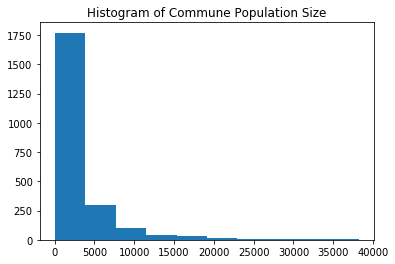

In [20]:
plt.hist(hh_sizes2016.query('Total < 40000')['Total'])
plt.title("Histogram of Commune Population Size")
plt.show()

In [33]:
def perc_hh(hh_sizes):
    #calculate the share of hh sizes for every commune
    hh_sizes.iloc[:,3:9] = hh_sizes.iloc[:,3:9].div(hh_sizes['Total'].values,axis=0)

def plot_pop_scatter(hh_sizes):
    #create scatterplot between Commune size and different HH sizes
    fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(20, 20))
    pos = 1
    
    for hh in ['1HH','2HH', '3HH', '4HH','5HH','6HH']:
        plt.subplot(2,3,pos)
        plt.ylabel("Share of %s" %hh)
        plt.xlabel("Population size")
        plt.scatter(data=hh_sizes, x="Total", y=hh, s=0.2 )
        pos = pos + 1
        
def plot_pop_r():
    # get r and p-values for different HH sizes over years
    HHsizes = ['1HH','2HH', '3HH', '4HH','5HH','6HH']
    years = ['2010', '2011', '2012', '2013', '2014', '2015','2016']
    hh_pop_r = pd.DataFrame(columns=HHsizes, index=years)
    hh_pop_p = pd.DataFrame(columns=HHsizes, index=years)
    
    for year in years:
        for hh in HHsizes:
            r,p = stats.pearsonr(x=globals()['hh_sizes%s' %year]["Total"],y=globals()['hh_sizes%s' %year][hh])
            hh_pop_r.loc[year,hh] = r
            hh_pop_p.loc[year,hh] = p
            
    #plot development of Pearson's R
    plt.figure(figsize=(20,10))
    hh_pop_r.plot(figsize=(20,10), title="Pearson'r Coefficient Between Populationn size and HH shares")
    #plt.title("Pearson'r Coefficient Between Population size and HH size")
    plt.ylabel('r-score')
    #plt.xticks(years)
    plt.show()
        
    return hh_pop_r , hh_pop_p

In [22]:
years = ['2010', '2011', '2012', '2013', '2014', '2015','2016']

#calc percentage
for year in years:
    perc_hh(hh_sizes=globals()['hh_sizes%s' %year])

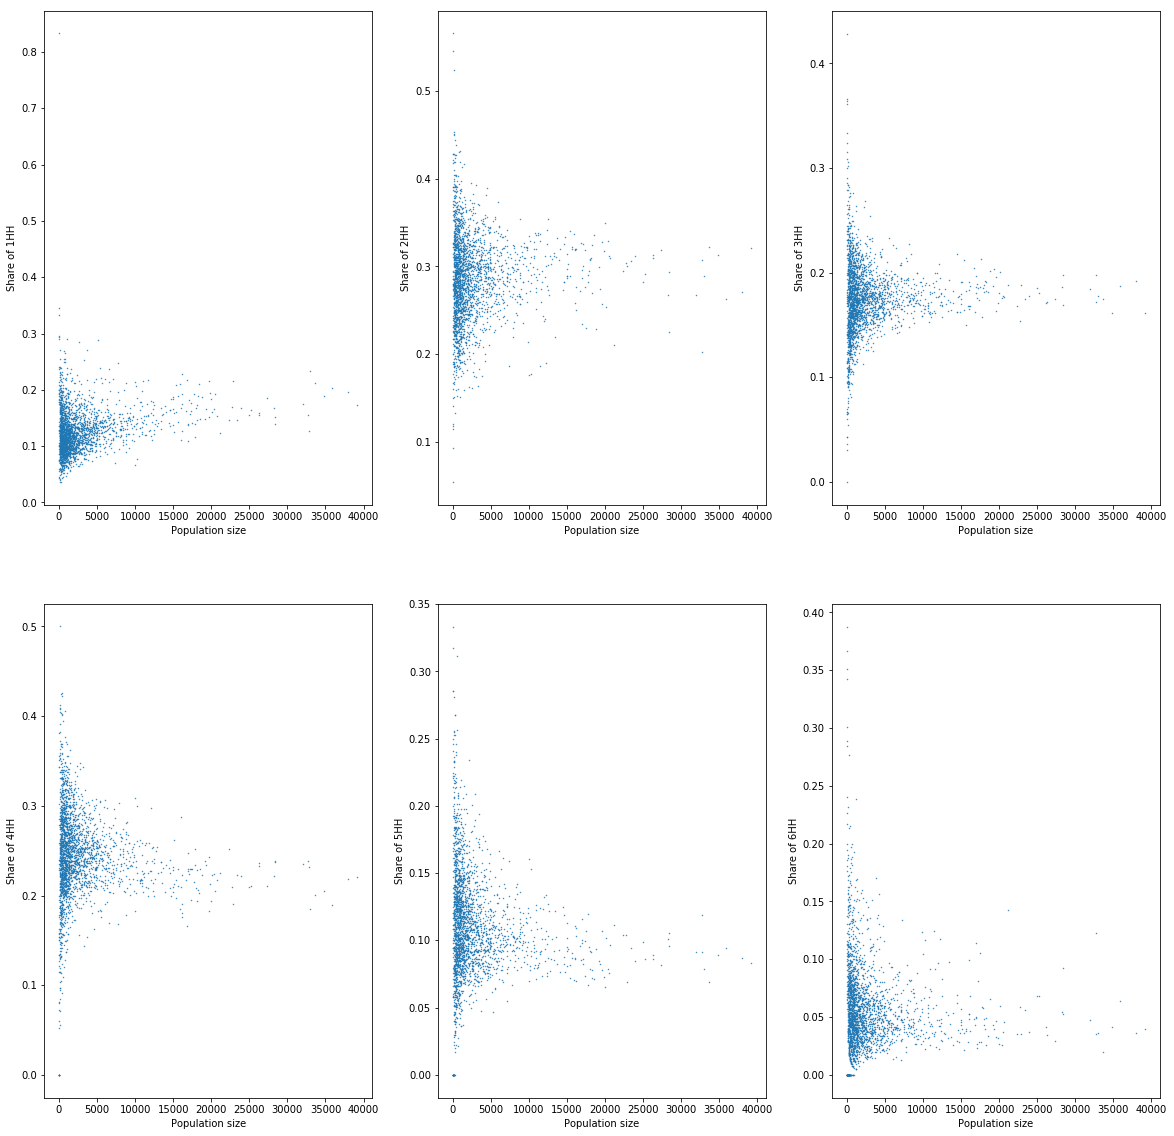

In [23]:
#plot example year 2016 (pop < 25000)
plot_pop_scatter(hh_sizes2013)

<Figure size 1440x720 with 0 Axes>

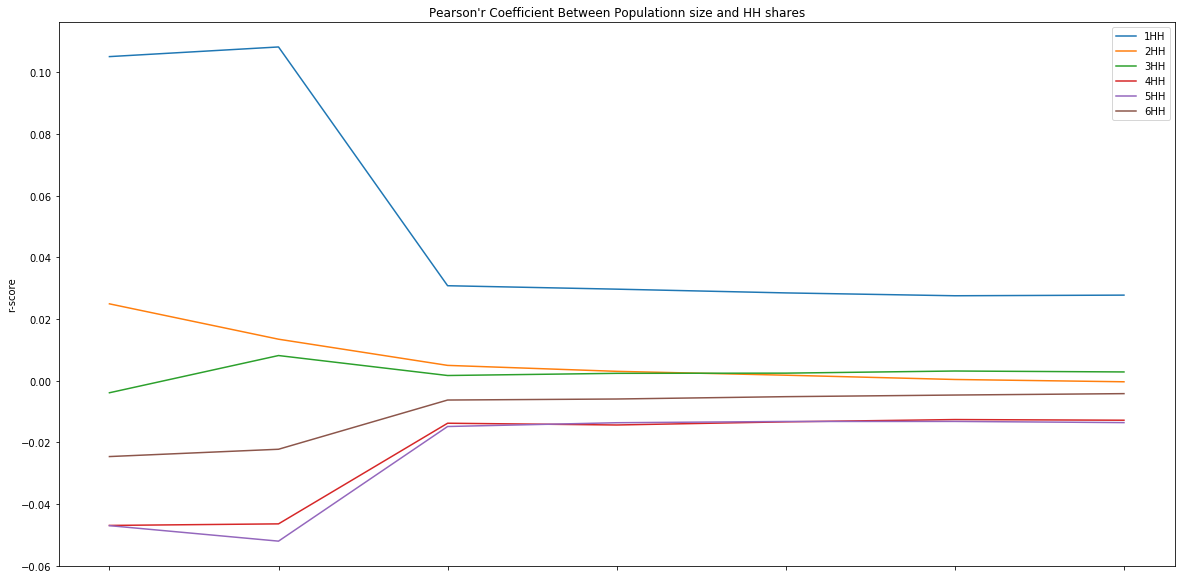

(            1HH          2HH         3HH        4HH        5HH         6HH
 2010   0.105058    0.0249157 -0.00390823 -0.0469136 -0.0469846  -0.0245891
 2011   0.108187    0.0134531  0.00815729 -0.0464079  -0.052006  -0.0222204
 2012  0.0307879   0.00496548  0.00168463 -0.0137827 -0.0148467 -0.00626495
 2013  0.0296744   0.00303651  0.00239046 -0.0143535 -0.0136233  -0.0059335
 2014  0.0284601     0.001783  0.00245052 -0.0133328 -0.0132156 -0.00517492
 2015  0.0275373  0.000397345  0.00313973  -0.012595 -0.0132002 -0.00464824
 2016   0.027742 -0.000347677  0.00283955 -0.0128093 -0.0135836 -0.00419152,
               1HH       2HH       3HH        4HH         5HH       6HH
 2010  9.12492e-08   0.20626  0.842869  0.0172769   0.0171086  0.212271
 2011  5.59695e-08  0.500677  0.683039  0.0201149  0.00918949  0.265976
 2012     0.124864  0.804556  0.933094   0.492151    0.459346  0.754877
 2013     0.146392  0.881879  0.906881   0.482427    0.504985  0.771548
 2014     0.167561  0.931114  0

In [24]:
plot_pop_r()    

**Interpretation:** There seems to be no linear correlation between population size and the hh shares

-> We try logtransformation of Population

In [34]:
#log-transform population size
years = ['2010', '2011', '2012', '2013', '2014', '2015','2016']
for year in years:
    globals()['hh_sizes%s' %year]['Total']= np.log(globals()['hh_sizes%s' %year]['Total'])


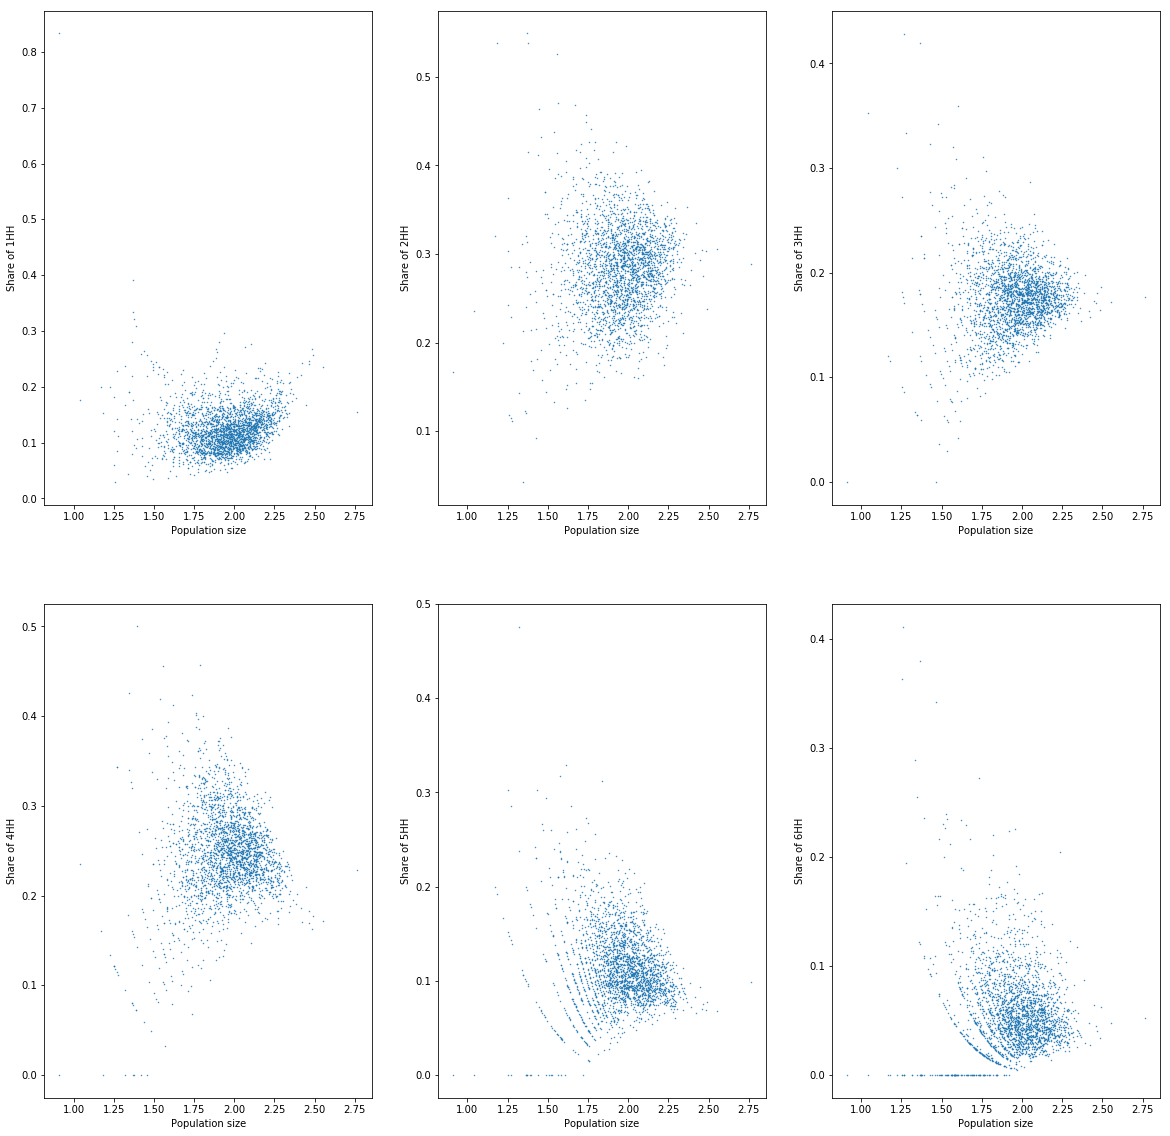

In [35]:
#check for 2012
plot_pop_scatter(hh_sizes2012)

<Figure size 1440x720 with 0 Axes>

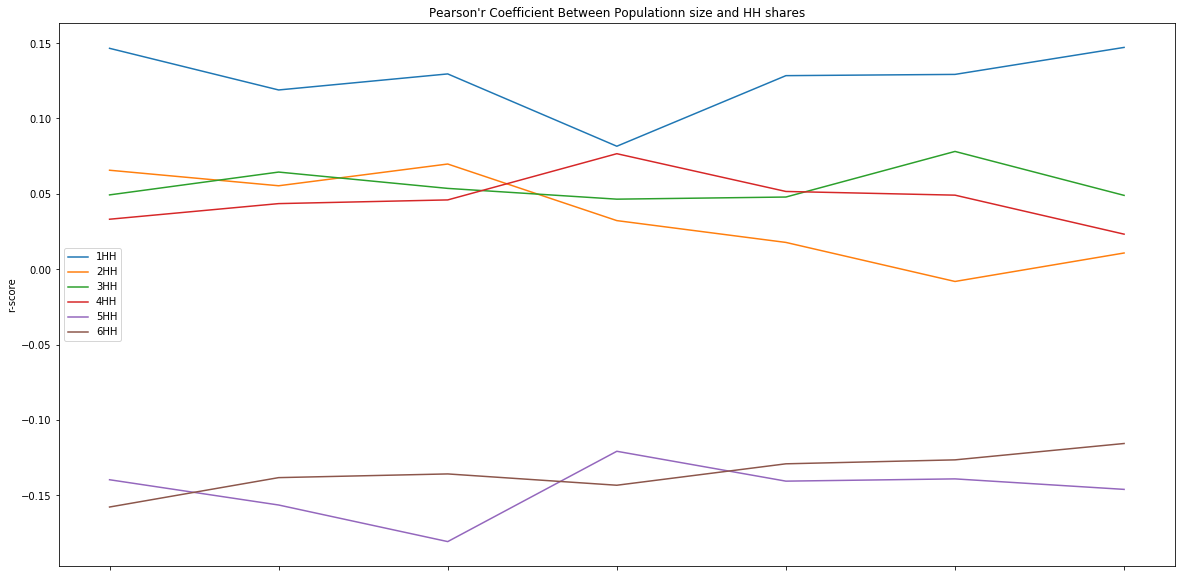

(           1HH         2HH        3HH        4HH       5HH       6HH
 2010  0.146499   0.0656282  0.0492674  0.0331271  -0.13968 -0.157779
 2011  0.118871   0.0553277  0.0644121  0.0434887 -0.156443  -0.13828
 2012  0.129517   0.0697526  0.0535807  0.0459379 -0.180709 -0.135826
 2013  0.081547   0.0322141  0.0464393  0.0765972 -0.120802 -0.143329
 2014   0.12837    0.017737  0.0478496   0.051548 -0.140614 -0.129114
 2015  0.129199 -0.00815549  0.0780966  0.0490936 -0.139112 -0.126496
 2016  0.147102   0.0107311  0.0489481  0.0232211 -0.146075  -0.11564,
               1HH          2HH         3HH          4HH          5HH  \
 2010  7.97451e-14  0.000861491   0.0124069    0.0928291  1.08348e-12   
 2011  2.35389e-09   0.00557901  0.00124878    0.0294167   3.2919e-15   
 2012  9.06602e-11  0.000500772  0.00753786    0.0219916  1.08123e-19   
 2013  6.41374e-05      0.11485   0.0229857  0.000174247  2.97413e-09   
 2014   4.1182e-10     0.389793   0.0202775    0.0123909  7.31767e-12   
 

In [134]:
plot_pop_r()

**Interpretation**: There is no correlation between commune size and its 
A main reason is, that there is only a few large communes and the statistic is heavily biased by the large amount of small ones.

# Post Data Wrangling for further Correlation Analysis

As seen before, the shares do not change significantly over the years. For that reason, the **year 2016** is chosen as example year.

In [100]:
#small post-datawrangling , keep only selected columns and calculate relative numbers if necessary
demographics = foreignswiss[["Gemeindecode","Gemeindename","Bevölkerungs-dichte pro km²", "Ausländer in %","Sozialhilfequote", "0-19 Jahre", "20-64 Jahre", "65 Jahre und mehr", "FDP 2)","SP","SVP"]]

hh_sizes2016 = hh_sizes2016.drop(columns="Unnamed: 0")
hh_sizes2016.iloc[:,2:8] = hh_sizes2016.iloc[:,2:8].div(hh_sizes2016['Total'].values,axis=0)

incomes_2016 = med_incomes[["Name","code","region","2016"]]
incomes_2016 = incomes_2016.rename(columns={'code': 'canton', '2016': 'median_income'})

In [119]:
merged1 = pd.merge(left=hh_sizes2016, right=incomes_2016, how='inner', left_on='Commune', right_on='Name').drop(columns="Name")
data2016 = pd.merge(left=merged1, right=demographics, how='inner', left_on="Commune", right_on= "Gemeindename").drop(columns=["Gemeindename"])
data2016.replace(["X","*"], np.nan, inplace=True)
data2016.to_csv("data2016.csv")

Ideas:

   
   - cluster rural and urban, check whether influence in hh shares
   - average over regions - maybe higher share in ticino?
   - 